In [1]:
# Run this cell first - installations
# In VS Code terminal or notebook cell with !

!pip install earthengine-api --quiet
!pip install geemap --quiet
!pip install xarray --quiet
!pip install rasterio --quiet
!pip install geopandas --quiet
!pip install pandas numpy matplotlib --quiet

print("✅ All packages installed successfully")

✅ All packages installed successfully


In [2]:
import ee

# Authenticate - this will open a browser window
ee.Authenticate()

# Initialize with your project
PROJECT_ID = 'ee-satyamshah444'

try:
    ee.Initialize(project=PROJECT_ID)
    print(f"✅ GEE initialized successfully with project: {PROJECT_ID}")
    
    # Quick test - get Sentinel-5P collection info
    s5p = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
    print(f"✅ Sentinel-5P NO2 collection accessible")
    print(f"   Total images available: {s5p.size().getInfo()}")
    
except Exception as e:
    print(f"❌ Error: {e}")

✅ GEE initialized successfully with project: ee-satyamshah444
✅ Sentinel-5P NO2 collection accessible
   Total images available: 38758


In [5]:
import osmnx as ox
import geopandas as gpd

def download_delhi_osm():
    """
    Download Delhi boundary from OpenStreetMap
    """
    # Download Delhi boundary
    delhi = ox.geocode_to_gdf("Delhi, India")
    
    # Save as shapefile
    output_path = "delhi_boundary"
    delhi.to_file(output_path, driver='ESRI Shapefile')
    
    print(f"Delhi shapefile saved to: {output_path}")
    print(f"CRS: {delhi.crs}")
    print(f"Bounds: {delhi.total_bounds}")
    
    return delhi

# Install: pip install osmnx
delhi_gdf = download_delhi_osm()

Delhi shapefile saved to: delhi_boundary
CRS: epsg:4326
Bounds: [77.0503708 28.4812209 77.2551392 28.6456842]


In [ ]:
import os

# Get current working directory
current_dir = os.getcwd()
print(f"Your shapefile is saved in: {current_dir}")

# Full path to shapefile folder
shapefile_path = os.path.join(current_dir, 'delhi_districts_final')
print(f"\nFull path: {shapefile_path}")

# List all files in the shapefile folder
if os.path.exists(shapefile_path):
    print(f"\nFiles in shapefile folder:")
    for file in os.listdir(shapefile_path):
        file_path = os.path.join(shapefile_path, file)
        size = os.path.getsize(file_path) / 1024  # KB
        print(f"  📄 {file} ({size:.1f} KB)")
else:
    print(" Folder not found!")

Your shapefile is saved in: /Users/satyamshah/Downloads

Full path: /Users/satyamshah/Downloads/delhi_districts_final

Files in shapefile folder:
  📄 delhi_districts_final.prj (0.1 KB)
  📄 delhi_districts_final.dbf (9.0 KB)
  📄 delhi_districts_final.shx (0.2 KB)
  📄 delhi_districts_final.cpg (0.0 KB)
  📄 delhi_districts_final.shp (42.2 KB)


CRS: EPSG:4326
Districts: 11
Columns: ['bbox_west', 'bbox_south', 'bbox_east', 'bbox_north', 'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'class', 'type', 'place_rank', 'importance', 'addresstyp', 'name', 'display_na', 'district', 'geometry']


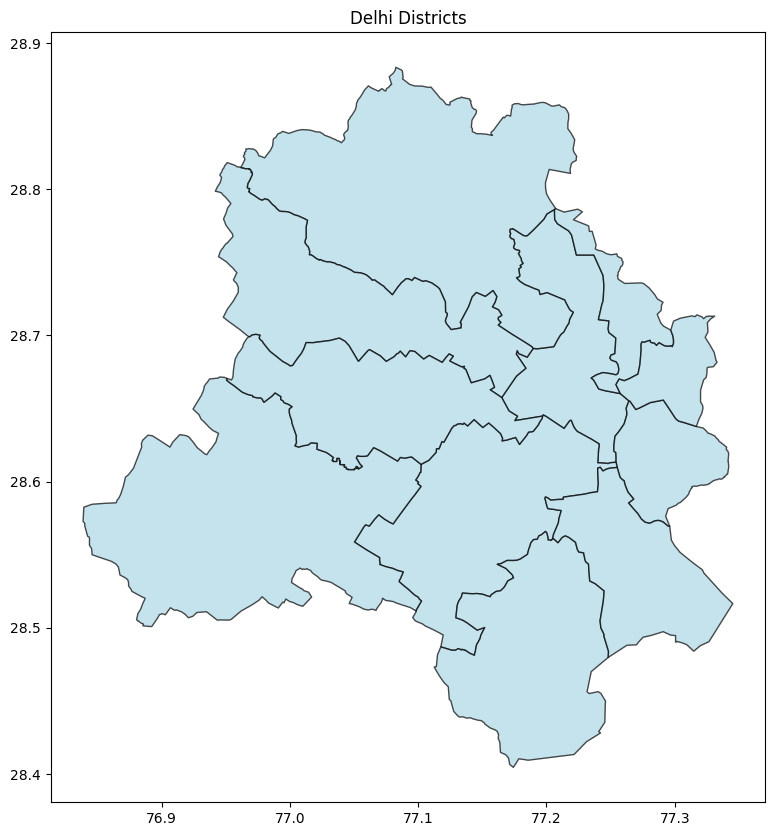

,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstyp,name,display_na,district,geometry
0,77.165164,28.612357,77.264271,28.786160,396709184,relation,1942443,28.699009,77.231463,boundary,administrative,10,0.452719,city_district,Central Delhi,"Central Delhi, Delhi, India",Central Delhi,"POLYGON ((77.16516 28.65752, 77.17662 28.6722,..."
1,77.252555,28.569515,77.342059,28.655820,226663165,relation,1942588,28.611743,77.298279,boundary,administrative,10,0.451668,city_district,East Delhi,"East Delhi, Delhi, India",East Delhi,"POLYGON ((77.25255 28.62086, 77.25258 28.62486..."
2,77.050371,28.481221,77.255139,28.645684,421167494,relation,2763541,28.613895,77.209006,boundary,administrative,9,0.702638,city,New Delhi,"New Delhi, Delhi, India",New Delhi,"POLYGON ((77.05037 28.55871, 77.05663 28.56759..."
3,76.961701,28.690917,77.223669,28.883446,396709185,relation,1942605,28.787228,77.098090,boundary,administrative,10,0.451998,city_district,North Delhi,"North Delhi, Delhi, India",North Delhi,"POLYGON ((76.9617 28.8149, 76.96224 28.81582, ..."
4,77.206226,28.660229,77.299053,28.786696,224268573,relation,1942602,28.723308,77.266857,boundary,administrative,10,0.452393,city_district,North East Delhi,"North East Delhi, Delhi, India",North East Delhi,"POLYGON ((77.20623 28.78616, 77.20728 28.7867,..."


In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your district shapefile
shapefile_path = "/Users/satyamshah/Downloads/delhi_districts_final"
delhi_districts = gpd.read_file(shapefile_path)

# Basic info
print(f"CRS: {delhi_districts.crs}")
print(f"Districts: {len(delhi_districts)}")
print(f"Columns: {delhi_districts.columns.tolist()}")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
delhi_districts.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.7)
ax.set_title('Delhi Districts')
plt.show()

delhi_districts.head()

In [16]:
# Convert to WGS84 if needed and get full Delhi boundary
delhi_districts = delhi_districts.to_crs("EPSG:4326")
delhi_boundary = delhi_districts.dissolve()

# Convert to GEE object
delhi_geojson = delhi_boundary.geometry.iloc[0].__geo_interface__
STUDY_AREA = ee.Geometry(delhi_geojson)

# Get bounds for reference
bounds = delhi_boundary.total_bounds
print(f"Bounds: West={bounds[0]:.2f}, South={bounds[1]:.2f}, East={bounds[2]:.2f}, North={bounds[3]:.2f}")

Bounds: West=76.84, South=28.40, East=77.35, North=28.88


In [17]:
# Sentinel-5P NO2 for Delhi, 2023
s5p_no2 = (ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
           .filterBounds(STUDY_AREA)
           .filterDate('2023-01-01', '2023-12-31')
           .select('tropospheric_NO2_column_number_density'))

# Get monthly means
def monthly_mean(month):
    monthly = s5p_no2.filter(ee.Filter.calendarRange(month, month, 'month')).mean()
    return monthly.set('month', month)

months = ee.List.sequence(1, 12)
monthly_no2 = ee.ImageCollection(months.map(monthly_mean))

print(f"Monthly composites created: {monthly_no2.size().getInfo()}")

Monthly composites created: 12


In [18]:
# Function to extract mean NO2 per district per month
def extract_district_no2(image):
    month = image.get('month')
    reduced = image.reduceRegions(
        collection=ee.FeatureCollection(delhi_districts.__geo_interface__),
        reducer=ee.Reducer.mean(),
        scale=1000
    )
    return reduced.map(lambda f: f.set('month', month))

# Extract
district_no2 = monthly_no2.map(extract_district_no2).flatten()

# Convert to dataframe
no2_data = district_no2.getInfo()
no2_list = []
for feature in no2_data['features']:
    props = feature['properties']
    no2_list.append({
        'district': props.get('district'),
        'month': props.get('month'),
        'no2_mean': props.get('mean')
    })

no2_df = pd.DataFrame(no2_list)
no2_df.head(12)

,district,month,no2_mean
0,Central Delhi,1,0.000241
1,East Delhi,1,0.000333
2,New Delhi,1,0.000254
3,North Delhi,1,0.000172
4,North East Delhi,1,0.000223
5,North West Delhi,1,0.000172
6,Shahdara,1,0.000289
7,South Delhi,1,0.000236
8,South East Delhi,1,0.000315
9,South West Delhi,1,0.000154


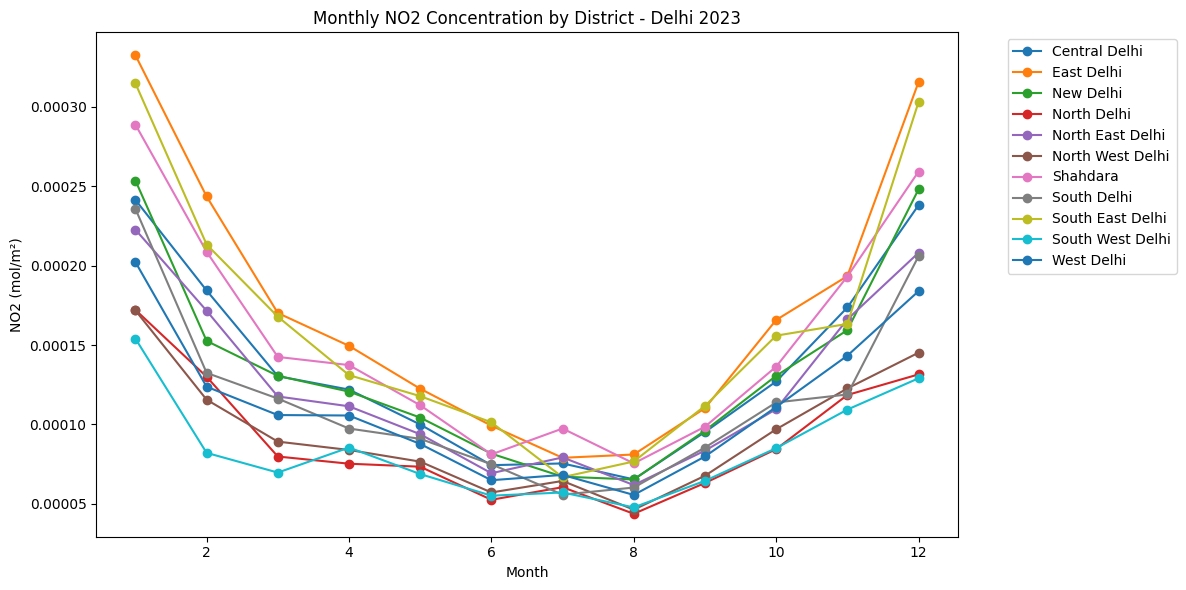

In [19]:
# Pivot for visualization
no2_pivot = no2_df.pivot(index='month', columns='district', values='no2_mean')

plt.figure(figsize=(12, 6))
no2_pivot.plot(ax=plt.gca(), marker='o')
plt.xlabel('Month')
plt.ylabel('NO2 (mol/m²)')
plt.title('Monthly NO2 Concentration by District - Delhi 2023')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
# Sentinel-2 Surface Reflectance - monthly composites
def get_s2_monthly(month):
    s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          .filterBounds(STUDY_AREA)
          .filterDate('2023-01-01', '2023-12-31')
          .filter(ee.Filter.calendarRange(month, month, 'month'))
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
          .median())
    
    # Calculate NDVI and NDBI (built-up index)
    ndvi = s2.normalizedDifference(['B8', 'B4']).rename('ndvi')
    ndbi = s2.normalizedDifference(['B11', 'B8']).rename('ndbi')
    
    return ndvi.addBands(ndbi).set('month', month)

months = ee.List.sequence(1, 12)
monthly_s2 = ee.ImageCollection(months.map(get_s2_monthly))

print(f"S2 monthly composites: {monthly_s2.size().getInfo()}")

S2 monthly composites: 12


In [21]:
def extract_district_s2(image):
    month = image.get('month')
    reduced = image.reduceRegions(
        collection=ee.FeatureCollection(delhi_districts.__geo_interface__),
        reducer=ee.Reducer.mean(),
        scale=100
    )
    return reduced.map(lambda f: f.set('month', month))

district_s2 = monthly_s2.map(extract_district_s2).flatten()

s2_data = district_s2.getInfo()
s2_list = []
for feature in s2_data['features']:
    props = feature['properties']
    s2_list.append({
        'district': props.get('district'),
        'month': props.get('month'),
        'ndvi': props.get('ndvi'),
        'ndbi': props.get('ndbi')
    })

s2_df = pd.DataFrame(s2_list)
s2_df.head(12)

,district,month,ndvi,ndbi
0,Central Delhi,1,0.256556,-0.033301
1,East Delhi,1,0.233312,-0.002609
2,New Delhi,1,0.312372,-0.009308
3,North Delhi,1,0.386411,-0.106870
4,North East Delhi,1,0.207206,0.008010
5,North West Delhi,1,0.334139,-0.107271
6,Shahdara,1,0.140148,0.026370
7,South Delhi,1,0.373571,-0.012538
8,South East Delhi,1,0.251303,0.006959
9,South West Delhi,1,0.415461,-0.190644


In [22]:
# ERA5 Monthly - Temperature, Wind, Humidity, Boundary Layer Height
def get_era5_monthly(month):
    era5 = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")
            .filterBounds(STUDY_AREA)
            .filter(ee.Filter.calendarRange(2023, 2023, 'year'))
            .filter(ee.Filter.calendarRange(month, month, 'month'))
            .first())
    
    return era5.select([
        'temperature_2m',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m', 
        'surface_pressure',
        'total_precipitation_sum'
    ]).set('month', month)

months = ee.List.sequence(1, 12)
monthly_era5 = ee.ImageCollection(months.map(get_era5_monthly))

print(f"ERA5 monthly composites: {monthly_era5.size().getInfo()}")

ERA5 monthly composites: 12


In [23]:
def extract_district_era5(image):
    month = image.get('month')
    reduced = image.reduceRegions(
        collection=ee.FeatureCollection(delhi_districts.__geo_interface__),
        reducer=ee.Reducer.mean(),
        scale=10000
    )
    return reduced.map(lambda f: f.set('month', month))

district_era5 = monthly_era5.map(extract_district_era5).flatten()

era5_data = district_era5.getInfo()
era5_list = []
for feature in era5_data['features']:
    props = feature['properties']
    era5_list.append({
        'district': props.get('district'),
        'month': props.get('month'),
        'temp_2m': props.get('temperature_2m'),
        'wind_u': props.get('u_component_of_wind_10m'),
        'wind_v': props.get('v_component_of_wind_10m'),
        'pressure': props.get('surface_pressure'),
        'precip': props.get('total_precipitation_sum')
    })

era5_df = pd.DataFrame(era5_list)
era5_df.head(12)

,district,month,temp_2m,wind_u,wind_v,pressure,precip
0,Central Delhi,1,285.732828,0.753612,-0.939955,99265.960417,0.027274
1,East Delhi,1,285.786325,0.738419,-0.939026,99253.085150,0.026254
2,New Delhi,1,285.748506,0.630305,-1.008628,99177.365648,0.026234
3,North Delhi,1,285.623139,0.775942,-0.920856,99284.676313,0.028090
4,North East Delhi,1,285.757673,0.769370,-0.922204,99266.954950,0.026850
5,North West Delhi,1,285.648136,0.684345,-0.955228,99308.245977,0.026757
6,Shahdara,1,285.766979,0.775972,-0.914102,99269.451417,0.026631
7,South Delhi,1,285.785611,0.555902,-1.058614,98965.545424,0.025187
8,South East Delhi,1,285.835205,0.625829,-1.013498,99190.816930,0.025177
9,South West Delhi,1,285.698414,0.532227,-0.962720,99308.726777,0.023328


In [24]:
# Merge all dataframes
master_df = no2_df.merge(s2_df, on=['district', 'month'], how='inner')
master_df = master_df.merge(era5_df, on=['district', 'month'], how='inner')

# Add wind speed (magnitude)
import numpy as np
master_df['wind_speed'] = np.sqrt(master_df['wind_u']**2 + master_df['wind_v']**2)

# Convert temperature to Celsius
master_df['temp_c'] = master_df['temp_2m'] - 273.15

# Drop intermediate columns
master_df = master_df.drop(columns=['temp_2m', 'wind_u', 'wind_v'])

print(f"Master dataset shape: {master_df.shape}")
master_df.head()

Master dataset shape: (132, 9)


,district,month,no2_mean,ndvi,ndbi,pressure,precip,wind_speed,temp_c
0,Central Delhi,1,0.000241,0.256556,-0.033301,99265.960417,0.027274,1.204760,12.582828
1,East Delhi,1,0.000333,0.233312,-0.002609,99253.085150,0.026254,1.194584,12.636325
2,New Delhi,1,0.000254,0.312372,-0.009308,99177.365648,0.026234,1.189376,12.598506
3,North Delhi,1,0.000172,0.386411,-0.106870,99284.676313,0.028090,1.204185,12.473139
4,North East Delhi,1,0.000223,0.207206,0.008010,99266.954950,0.026850,1.200996,12.607673


In [25]:
# Check for missing values and basic stats
print("Missing values:")
print(master_df.isnull().sum())
print("\n" + "="*50)
print("\nDescriptive statistics:")
master_df.describe()

Missing values:
district      0
month         0
no2_mean      0
ndvi          5
ndbi          5
pressure      0
precip        0
wind_speed    0
temp_c        0
dtype: int64


Descriptive statistics:


,month,no2_mean,ndvi,ndbi,pressure,precip,wind_speed,temp_c
count,132.000000,132.000000,127.000000,127.000000,132.000000,132.000000,132.000000,132.000000
mean,6.500000,0.000125,0.314483,-0.052223,98431.707877,0.058855,1.148005,24.227315
std,3.465203,0.000063,0.097844,0.048653,604.073789,0.073414,0.373766,5.905965
min,1.000000,0.000044,0.051550,-0.208879,97366.222757,0.000306,0.498424,12.473139
25%,3.750000,0.000078,0.243175,-0.084068,97729.684819,0.008512,0.798850,20.348747
50%,6.500000,0.000111,0.307976,-0.048934,98453.218534,0.032338,1.175173,26.191479
75%,9.250000,0.000155,0.384820,-0.019695,98964.218172,0.073264,1.366815,29.178253
max,12.000000,0.000333,0.570290,0.051815,99316.009473,0.293806,2.053761,31.575934


In [26]:
# Fill missing NDVI/NDBI with district-wise mean
master_df['ndvi'] = master_df.groupby('district')['ndvi'].transform(lambda x: x.fillna(x.mean()))
master_df['ndbi'] = master_df.groupby('district')['ndbi'].transform(lambda x: x.fillna(x.mean()))

# Verify no missing values
print(f"Missing values after imputation: {master_df.isnull().sum().sum()}")

# Save to CSV
master_df.to_csv('delhi_air_quality_dataset.csv', index=False)
print(f"Dataset saved: delhi_air_quality_dataset.csv")

Missing values after imputation: 0
Dataset saved: delhi_air_quality_dataset.csv


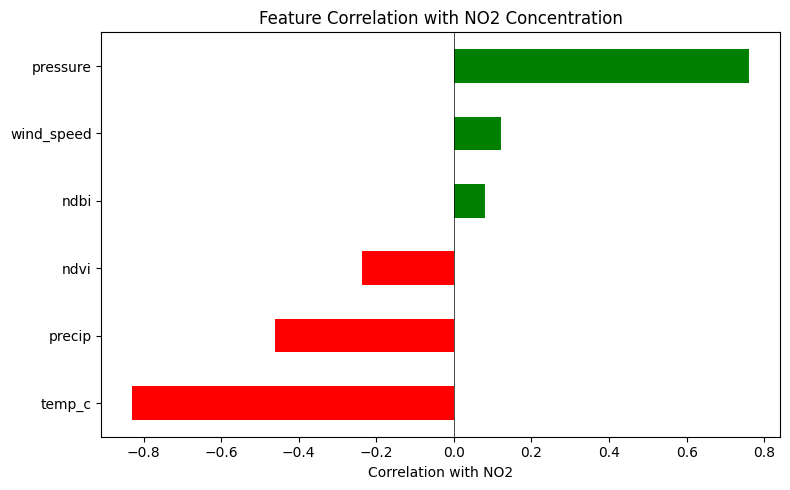

temp_c       -0.828909
precip       -0.460597
ndvi         -0.237565
ndbi          0.079047
wind_speed    0.120618
pressure      0.761113
Name: no2_mean, dtype: float64

In [27]:
# Feature correlation with NO2
features = ['ndvi', 'ndbi', 'pressure', 'precip', 'wind_speed', 'temp_c']

fig, ax = plt.subplots(figsize=(8, 5))
correlations = master_df[features + ['no2_mean']].corr()['no2_mean'].drop('no2_mean').sort_values()
correlations.plot(kind='barh', ax=ax, color=['red' if x < 0 else 'green' for x in correlations])
ax.set_xlabel('Correlation with NO2')
ax.set_title('Feature Correlation with NO2 Concentration')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

correlations

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hold out months 11, 12 for testing (winter high-pollution period)
train_df = master_df[master_df['month'] <= 10]
test_df = master_df[master_df['month'] > 10]

# Features and target
feature_cols = ['ndvi', 'ndbi', 'pressure', 'precip', 'wind_speed', 'temp_c']
target_col = 'no2_mean'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape[0]} samples (months 1-10)")
print(f"Test: {X_test_scaled.shape[0]} samples (months 11-12)")

Train: 110 samples (months 1-10)
Test: 22 samples (months 11-12)


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=3, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluation function
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

results = [
    evaluate(y_test, rf_pred, 'Random Forest'),
    evaluate(y_test, xgb_pred, 'XGBoost')
]

pd.DataFrame(results)

,Model,RMSE,MAE,R2
0,Random Forest,0.000049,0.00004,0.288476
1,XGBoost,0.000091,0.00007,-1.455193


In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Define model with dropout for uncertainty
class AQNet(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        super(AQNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

model = AQNet(input_dim=6, dropout_rate=0.2)
print(model)

AQNet(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


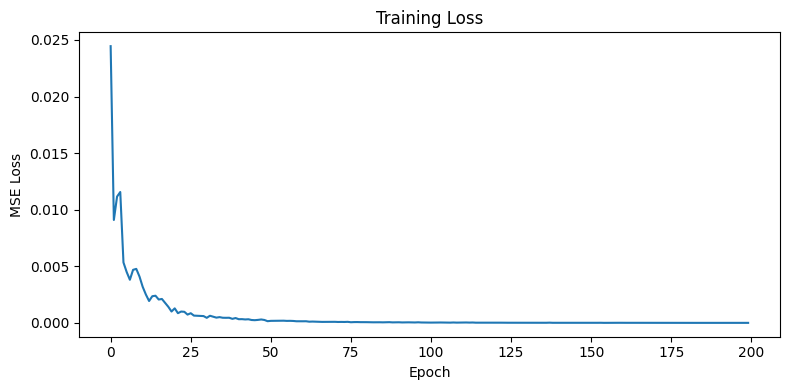

Final training loss: 0.0000050733


In [31]:
# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop
epochs = 200
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.tight_layout()
plt.show()

print(f"Final training loss: {train_losses[-1]:.10f}")

In [32]:
# Monte Carlo Dropout - run multiple forward passes with dropout enabled
def predict_with_uncertainty(model, X, n_samples=100):
    model.train()  # Keep dropout active
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            pred = model(X)
            predictions.append(pred.numpy())
    
    predictions = np.array(predictions).squeeze()
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    
    return mean_pred, std_pred

# Get predictions with uncertainty
nn_pred, nn_uncertainty = predict_with_uncertainty(model, X_test_tensor, n_samples=100)

# Evaluate
nn_results = evaluate(y_test.values, nn_pred, 'Neural Network (MC Dropout)')
print(pd.DataFrame([nn_results]))

print(f"\nMean uncertainty (std): {nn_uncertainty.mean():.6f}")
print(f"Uncertainty range: [{nn_uncertainty.min():.6f}, {nn_uncertainty.max():.6f}]")

                         Model      RMSE       MAE         R2
0  Neural Network (MC Dropout)  0.000236  0.000176 -15.578273

Mean uncertainty (std): 0.001433
Uncertainty range: [0.001055, 0.002638]


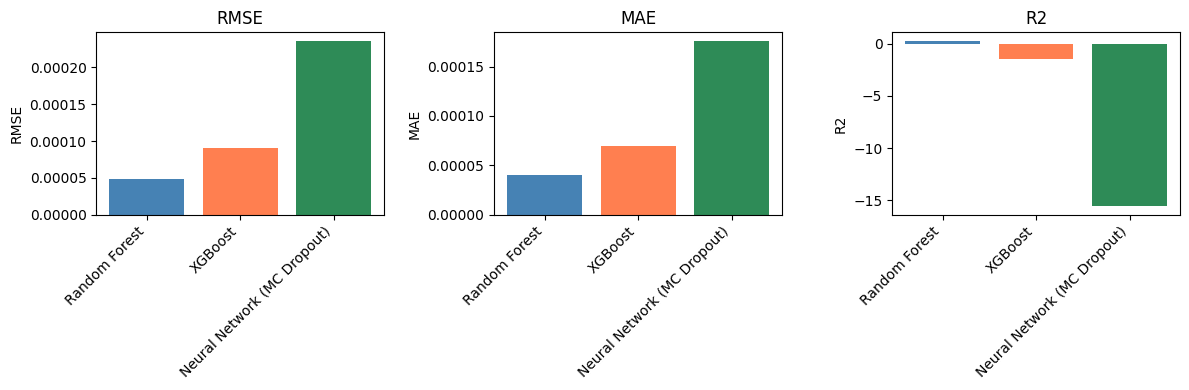

,Model,RMSE,MAE,R2
0,Random Forest,0.000049,0.000040,0.288476
1,XGBoost,0.000091,0.000070,-1.455193
2,Neural Network (MC Dropout),0.000236,0.000176,-15.578273


In [33]:
# Compile all results
all_results = [
    evaluate(y_test.values, rf_pred, 'Random Forest'),
    evaluate(y_test.values, xgb_pred, 'XGBoost'),
    evaluate(y_test.values, nn_pred, 'Neural Network (MC Dropout)')
]

results_df = pd.DataFrame(all_results)
results_df = results_df.round(6)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for idx, metric in enumerate(['RMSE', 'MAE', 'R2']):
    ax = axes[idx]
    colors = ['steelblue', 'coral', 'seagreen']
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors)
    ax.set_ylabel(metric)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.set_title(metric)

plt.tight_layout()
plt.show()

results_df

In [34]:
# Fetch 3 years of NO2 data
years = [2021, 2022, 2023]
all_no2_data = []

for year in years:
    s5p_no2 = (ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
               .filterBounds(STUDY_AREA)
               .filterDate(f'{year}-01-01', f'{year}-12-31')
               .select('tropospheric_NO2_column_number_density'))
    
    def monthly_mean(month):
        monthly = s5p_no2.filter(ee.Filter.calendarRange(month, month, 'month')).mean()
        return monthly.set('month', month).set('year', year)
    
    months = ee.List.sequence(1, 12)
    monthly_no2 = ee.ImageCollection(months.map(monthly_mean))
    
    def extract_district_no2(image):
        month = image.get('month')
        yr = image.get('year')
        reduced = image.reduceRegions(
            collection=ee.FeatureCollection(delhi_districts.__geo_interface__),
            reducer=ee.Reducer.mean(),
            scale=1000
        )
        return reduced.map(lambda f: f.set('month', month).set('year', yr))
    
    district_no2 = monthly_no2.map(extract_district_no2).flatten()
    no2_data = district_no2.getInfo()
    
    for feature in no2_data['features']:
        props = feature['properties']
        all_no2_data.append({
            'district': props.get('district'),
            'year': props.get('year'),
            'month': props.get('month'),
            'no2_mean': props.get('mean')
        })

no2_df_expanded = pd.DataFrame(all_no2_data)
print(f"Expanded NO2 dataset: {no2_df_expanded.shape}")
no2_df_expanded.head()

Expanded NO2 dataset: (396, 4)


,district,year,month,no2_mean
0,Central Delhi,2021,1,0.000288
1,East Delhi,2021,1,0.000354
2,New Delhi,2021,1,0.000252
3,North Delhi,2021,1,0.000184
4,North East Delhi,2021,1,0.000253


In [37]:
all_s2_data = []

for year in years:
    for month in range(1, 13):
        try:
            s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                  .filterBounds(STUDY_AREA)
                  .filterDate(f'{year}-01-01', f'{year}-12-31')
                  .filter(ee.Filter.calendarRange(month, month, 'month'))
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
                  .median())
            
            ndvi = s2.normalizedDifference(['B8', 'B4']).rename('ndvi')
            ndbi = s2.normalizedDifference(['B11', 'B8']).rename('ndbi')
            combined = ndvi.addBands(ndbi)
            
            reduced = combined.reduceRegions(
                collection=ee.FeatureCollection(delhi_districts.__geo_interface__),
                reducer=ee.Reducer.mean(),
                scale=100
            )
            
            s2_data = reduced.getInfo()
            
            for feature in s2_data['features']:
                props = feature['properties']
                if props.get('ndvi') is not None:
                    all_s2_data.append({
                        'district': props.get('district'),
                        'year': year,
                        'month': month,
                        'ndvi': props.get('ndvi'),
                        'ndbi': props.get('ndbi')
                    })
        except:
            continue

s2_df_expanded = pd.DataFrame(all_s2_data)
print(f"Expanded S2 dataset: {s2_df_expanded.shape}")

Expanded S2 dataset: (376, 5)


In [38]:
all_era5_data = []

for year in years:
    for month in range(1, 13):
        try:
            era5 = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")
                    .filterBounds(STUDY_AREA)
                    .filter(ee.Filter.calendarRange(year, year, 'year'))
                    .filter(ee.Filter.calendarRange(month, month, 'month'))
                    .first()
                    .select(['temperature_2m', 'u_component_of_wind_10m', 
                            'v_component_of_wind_10m', 'surface_pressure', 
                            'total_precipitation_sum']))
            
            reduced = era5.reduceRegions(
                collection=ee.FeatureCollection(delhi_districts.__geo_interface__),
                reducer=ee.Reducer.mean(),
                scale=10000
            )
            
            era5_data = reduced.getInfo()
            
            for feature in era5_data['features']:
                props = feature['properties']
                all_era5_data.append({
                    'district': props.get('district'),
                    'year': year,
                    'month': month,
                    'temp_2m': props.get('temperature_2m'),
                    'wind_u': props.get('u_component_of_wind_10m'),
                    'wind_v': props.get('v_component_of_wind_10m'),
                    'pressure': props.get('surface_pressure'),
                    'precip': props.get('total_precipitation_sum')
                })
        except:
            continue

era5_df_expanded = pd.DataFrame(all_era5_data)
print(f"Expanded ERA5 dataset: {era5_df_expanded.shape}")

Expanded ERA5 dataset: (396, 8)


In [39]:
# Merge all three dataframes
master_expanded = no2_df_expanded.merge(s2_df_expanded, on=['district', 'year', 'month'], how='inner')
master_expanded = master_expanded.merge(era5_df_expanded, on=['district', 'year', 'month'], how='inner')

# Calculate derived features
master_expanded['wind_speed'] = np.sqrt(master_expanded['wind_u']**2 + master_expanded['wind_v']**2)
master_expanded['temp_c'] = master_expanded['temp_2m'] - 273.15

# Drop intermediate columns
master_expanded = master_expanded.drop(columns=['temp_2m', 'wind_u', 'wind_v'])

# Fill missing NDVI/NDBI
master_expanded['ndvi'] = master_expanded.groupby('district')['ndvi'].transform(lambda x: x.fillna(x.mean()))
master_expanded['ndbi'] = master_expanded.groupby('district')['ndbi'].transform(lambda x: x.fillna(x.mean()))

print(f"Final dataset shape: {master_expanded.shape}")
print(f"Missing values: {master_expanded.isnull().sum().sum()}")
master_expanded.to_csv('delhi_aq_expanded.csv', index=False)
master_expanded.head()

Final dataset shape: (376, 10)
Missing values: 0


,district,year,month,no2_mean,ndvi,ndbi,pressure,precip,wind_speed,temp_c
0,Central Delhi,2021,1,0.000288,0.140904,-0.100220,99060.032355,0.037869,1.079657,13.576797
1,East Delhi,2021,1,0.000354,0.088862,-0.106156,99049.913822,0.035251,1.094694,13.668392
2,New Delhi,2021,1,0.000252,0.206680,-0.067993,98971.660328,0.036888,1.035634,13.680166
3,North Delhi,2021,1,0.000184,0.209689,-0.141557,99081.653844,0.039489,1.043068,13.478005
4,North East Delhi,2021,1,0.000253,0.096313,-0.078059,99059.282502,0.036728,1.097323,13.617100


In [40]:
# Split: 2021-2022 train, 2023 test
train_exp = master_expanded[master_expanded['year'] < 2023]
test_exp = master_expanded[master_expanded['year'] == 2023]

feature_cols = ['ndvi', 'ndbi', 'pressure', 'precip', 'wind_speed', 'temp_c']
target_col = 'no2_mean'

X_train_exp = train_exp[feature_cols]
y_train_exp = train_exp[target_col]
X_test_exp = test_exp[feature_cols]
y_test_exp = test_exp[target_col]

scaler_exp = StandardScaler()
X_train_exp_scaled = scaler_exp.fit_transform(X_train_exp)
X_test_exp_scaled = scaler_exp.transform(X_test_exp)

print(f"Train: {X_train_exp_scaled.shape[0]} samples (2021-2022)")
print(f"Test: {X_test_exp_scaled.shape[0]} samples (2023)")

Train: 249 samples (2021-2022)
Test: 127 samples (2023)


In [41]:
# Random Forest
rf_model_exp = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model_exp.fit(X_train_exp_scaled, y_train_exp)
rf_pred_exp = rf_model_exp.predict(X_test_exp_scaled)

# XGBoost
xgb_model_exp = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=3, learning_rate=0.1)
xgb_model_exp.fit(X_train_exp_scaled, y_train_exp)
xgb_pred_exp = xgb_model_exp.predict(X_test_exp_scaled)

# Results
results_exp = [
    evaluate(y_test_exp.values, rf_pred_exp, 'Random Forest'),
    evaluate(y_test_exp.values, xgb_pred_exp, 'XGBoost')
]

pd.DataFrame(results_exp)

,Model,RMSE,MAE,R2
0,Random Forest,0.000039,0.000030,0.633231
1,XGBoost,0.000064,0.000052,-0.018548


In [42]:
# Convert to tensors
X_train_t = torch.FloatTensor(X_train_exp_scaled)
y_train_t = torch.FloatTensor(y_train_exp.values).reshape(-1, 1)
X_test_t = torch.FloatTensor(X_test_exp_scaled)
y_test_t = torch.FloatTensor(y_test_exp.values).reshape(-1, 1)

# Fresh model
torch.manual_seed(42)
model_exp = AQNet(input_dim=6, dropout_rate=0.2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_exp.parameters(), lr=0.005, weight_decay=1e-4)

# Train
for epoch in range(300):
    model_exp.train()
    optimizer.zero_grad()
    outputs = model_exp(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

# Predict with uncertainty
nn_pred_exp, nn_uncertainty_exp = predict_with_uncertainty(model_exp, X_test_t, n_samples=100)

# Evaluate
nn_result = evaluate(y_test_exp.values, nn_pred_exp, 'Neural Network (MC Dropout)')
print(pd.DataFrame([nn_result]))
print(f"Mean uncertainty: {nn_uncertainty_exp.mean():.6f}")

                         Model      RMSE       MAE         R2
0  Neural Network (MC Dropout)  0.001013  0.000698 -252.95965
Mean uncertainty: 0.002976


In [43]:
# Simpler architecture for small dataset
class AQNetSimple(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super(AQNetSimple, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        return self.network(x)

torch.manual_seed(42)
model_simple = AQNetSimple(input_dim=6, dropout_rate=0.3)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_simple.parameters(), lr=0.001, weight_decay=1e-3)

# Train with early stopping tracking
for epoch in range(500):
    model_simple.train()
    optimizer.zero_grad()
    outputs = model_simple(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

# Predict with uncertainty
nn_pred_simple, nn_unc_simple = predict_with_uncertainty(model_simple, X_test_t, n_samples=100)
nn_result_simple = evaluate(y_test_exp.values, nn_pred_simple, 'NN Simple (MC Dropout)')

print(pd.DataFrame([nn_result_simple]))
print(f"Mean uncertainty: {nn_unc_simple.mean():.6f}")

                    Model      RMSE       MAE            R2
0  NN Simple (MC Dropout)  0.007302  0.005884 -13180.714481
Mean uncertainty: 0.012156


In [44]:
# Train multiple RF models with different seeds for uncertainty
n_models = 20
ensemble_preds = []

for i in range(n_models):
    rf_temp = RandomForestRegressor(n_estimators=100, random_state=i, max_depth=5)
    rf_temp.fit(X_train_exp_scaled, y_train_exp)
    ensemble_preds.append(rf_temp.predict(X_test_exp_scaled))

ensemble_preds = np.array(ensemble_preds)
rf_ensemble_mean = ensemble_preds.mean(axis=0)
rf_ensemble_std = ensemble_preds.std(axis=0)

rf_ensemble_result = evaluate(y_test_exp.values, rf_ensemble_mean, 'RF Ensemble (20 models)')
print(pd.DataFrame([rf_ensemble_result]))
print(f"Mean uncertainty: {rf_ensemble_std.mean():.6f}")
print(f"Uncertainty range: [{rf_ensemble_std.min():.6f}, {rf_ensemble_std.max():.6f}]")

                     Model      RMSE      MAE        R2
0  RF Ensemble (20 models)  0.000038  0.00003  0.635858
Mean uncertainty: 0.000002
Uncertainty range: [0.000001, 0.000007]


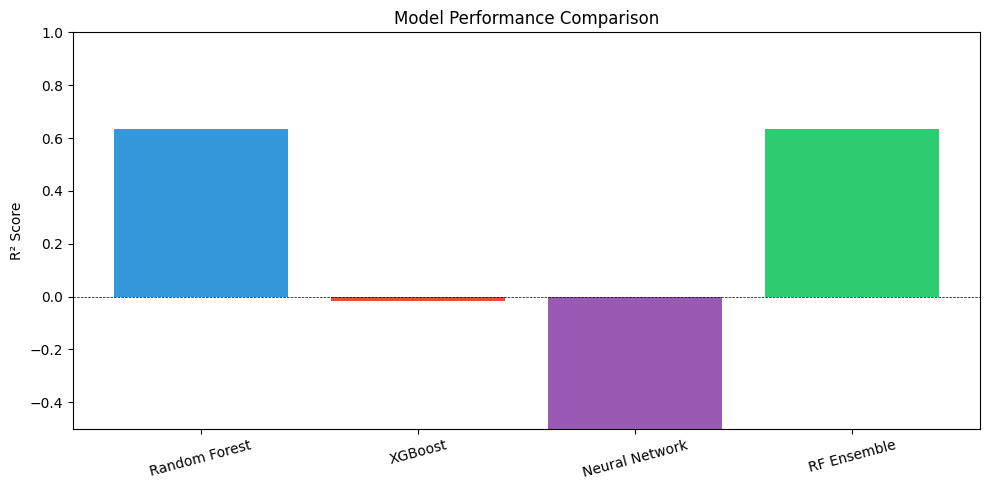

,Model,RMSE,MAE,R2,Has_Uncertainty
0,Random Forest,0.000039,0.000030,0.633231,No
1,XGBoost,0.000064,0.000052,-0.018548,No
2,Neural Network,0.007302,0.005884,-13180.714481,Yes
3,RF Ensemble,0.000038,0.000030,0.635858,Yes


In [45]:
# All results
final_results = [
    evaluate(y_test_exp.values, rf_pred_exp, 'Random Forest'),
    evaluate(y_test_exp.values, xgb_pred_exp, 'XGBoost'),
    evaluate(y_test_exp.values, nn_pred_simple, 'Neural Network'),
    evaluate(y_test_exp.values, rf_ensemble_mean, 'RF Ensemble')
]

final_df = pd.DataFrame(final_results)

# Add uncertainty column
final_df['Has_Uncertainty'] = ['No', 'No', 'Yes', 'Yes']

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#3498db', '#e74c3c', '#9b59b6', '#2ecc71']
x = range(len(final_df))
bars = ax.bar(x, final_df['R2'], color=colors)
ax.set_xticks(x)
ax.set_xticklabels(final_df['Model'], rotation=15)
ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim(-0.5, 1)
plt.tight_layout()
plt.show()

final_df

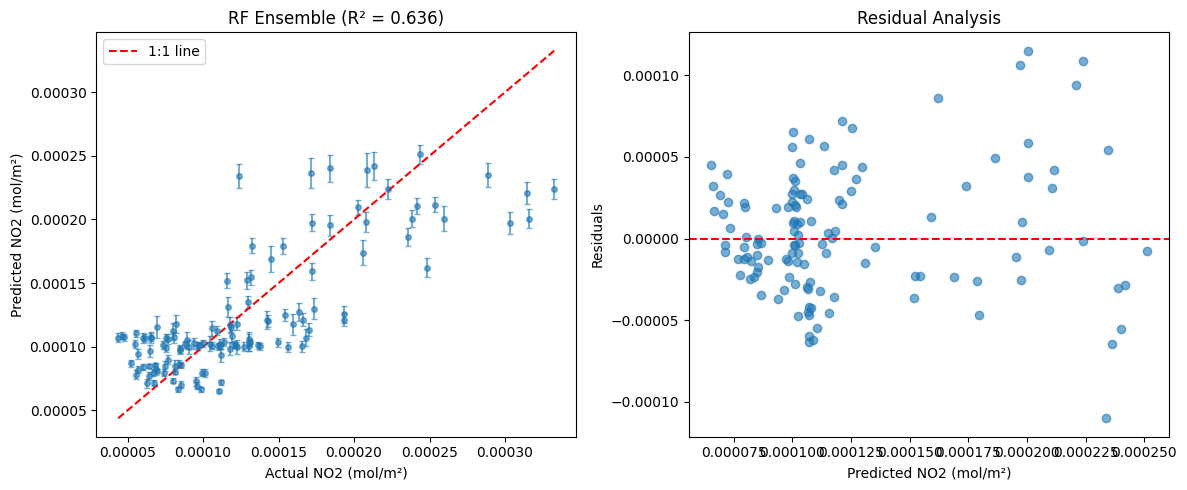

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: RF Ensemble predictions
ax1 = axes[0]
ax1.errorbar(y_test_exp.values, rf_ensemble_mean, yerr=rf_ensemble_std*2, 
             fmt='o', alpha=0.6, capsize=2, markersize=4)
ax1.plot([y_test_exp.min(), y_test_exp.max()], 
         [y_test_exp.min(), y_test_exp.max()], 'r--', label='1:1 line')
ax1.set_xlabel('Actual NO2 (mol/m²)')
ax1.set_ylabel('Predicted NO2 (mol/m²)')
ax1.set_title(f'RF Ensemble (R² = {0.636:.3f})')
ax1.legend()

# Plot 2: Residuals
ax2 = axes[1]
residuals = y_test_exp.values - rf_ensemble_mean
ax2.scatter(rf_ensemble_mean, residuals, alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted NO2 (mol/m²)')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Analysis')

plt.tight_layout()
plt.show()

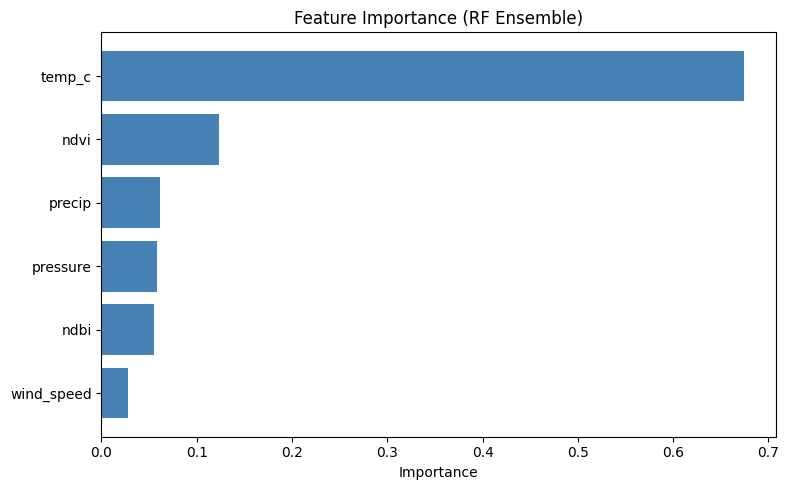

,Feature,Importance
5,temp_c,0.674054
0,ndvi,0.123147
3,precip,0.061515
2,pressure,0.058399
1,ndbi,0.055037
4,wind_speed,0.027847


In [47]:
# Feature importance from RF Ensemble (average across all models)
feature_importance = np.zeros(len(feature_cols))

for i in range(n_models):
    rf_temp = RandomForestRegressor(n_estimators=100, random_state=i, max_depth=5)
    rf_temp.fit(X_train_exp_scaled, y_train_exp)
    feature_importance += rf_temp.feature_importances_

feature_importance /= n_models

# Plot
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance (RF Ensemble)')
plt.tight_layout()
plt.show()

importance_df.sort_values('Importance', ascending=False)

In [48]:
# Add predictions to test data
test_results = test_exp.copy()
test_results['predicted'] = rf_ensemble_mean
test_results['uncertainty'] = rf_ensemble_std
test_results['residual'] = test_results['no2_mean'] - test_results['predicted']

# District-wise performance
district_performance = test_results.groupby('district').agg({
    'no2_mean': 'mean',
    'predicted': 'mean',
    'uncertainty': 'mean',
    'residual': lambda x: np.sqrt((x**2).mean())  # RMSE per district
}).rename(columns={'residual': 'rmse'})

district_performance['bias'] = district_performance['predicted'] - district_performance['no2_mean']

district_performance.sort_values('rmse')

,no2_mean,predicted,uncertainty,rmse,bias
district,,,,,
North West Delhi,0.000095,0.000115,0.000002,0.000027,0.000020
North Delhi,0.000090,0.000110,0.000002,0.000028,0.000020
South Delhi,0.000116,0.000119,0.000003,0.000028,0.000003
North East Delhi,0.000129,0.000132,0.000003,0.000029,0.000003
South West Delhi,0.000084,0.000105,0.000002,0.000031,0.000021
Central Delhi,0.000141,0.000132,0.000003,0.000032,-0.000009
New Delhi,0.000134,0.000118,0.000003,0.000037,-0.000016
West Delhi,0.000111,0.000129,0.000002,0.000038,0.000018
Shahdara,0.000158,0.000133,0.000003,0.000040,-0.000025


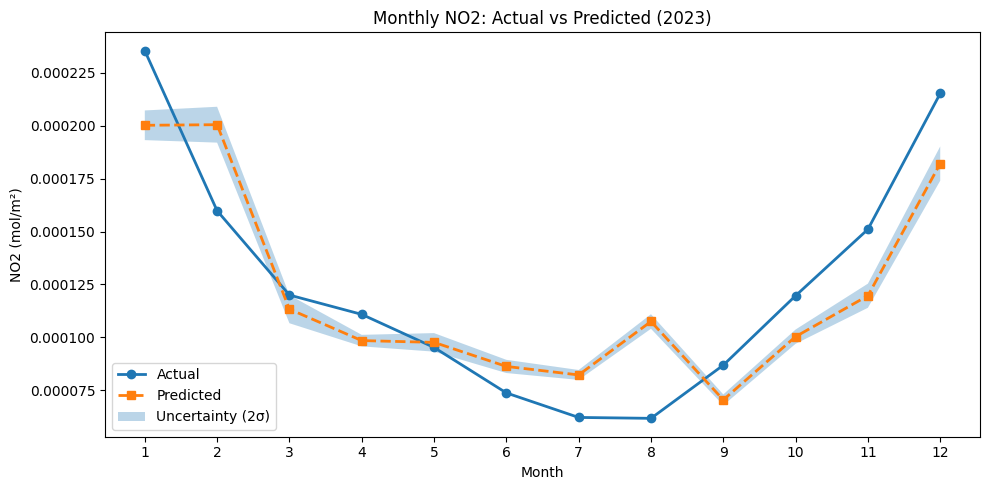

,no2_mean,predicted,uncertainty,rmse
month,,,,
1,0.000235,0.000200,0.000004,0.000053
2,0.000160,0.000201,0.000004,0.000049
3,0.000120,0.000113,0.000003,0.000034
4,0.000111,0.000098,0.000001,0.000023
5,0.000095,0.000098,0.000002,0.000016
6,0.000074,0.000086,0.000002,0.000025
7,0.000062,0.000082,0.000001,0.000021
8,0.000062,0.000108,0.000002,0.000047
9,0.000087,0.000070,0.000001,0.000025


In [49]:
# Monthly performance
monthly_performance = test_results.groupby('month').agg({
    'no2_mean': 'mean',
    'predicted': 'mean',
    'uncertainty': 'mean',
    'residual': lambda x: np.sqrt((x**2).mean())
}).rename(columns={'residual': 'rmse'})

# Plot actual vs predicted by month
fig, ax = plt.subplots(figsize=(10, 5))
months = monthly_performance.index
ax.plot(months, monthly_performance['no2_mean'], 'o-', label='Actual', linewidth=2)
ax.plot(months, monthly_performance['predicted'], 's--', label='Predicted', linewidth=2)
ax.fill_between(months, 
                monthly_performance['predicted'] - monthly_performance['uncertainty']*2,
                monthly_performance['predicted'] + monthly_performance['uncertainty']*2,
                alpha=0.3, label='Uncertainty (2σ)')
ax.set_xlabel('Month')
ax.set_ylabel('NO2 (mol/m²)')
ax.set_title('Monthly NO2: Actual vs Predicted (2023)')
ax.legend()
ax.set_xticks(months)
plt.tight_layout()
plt.show()

monthly_performance

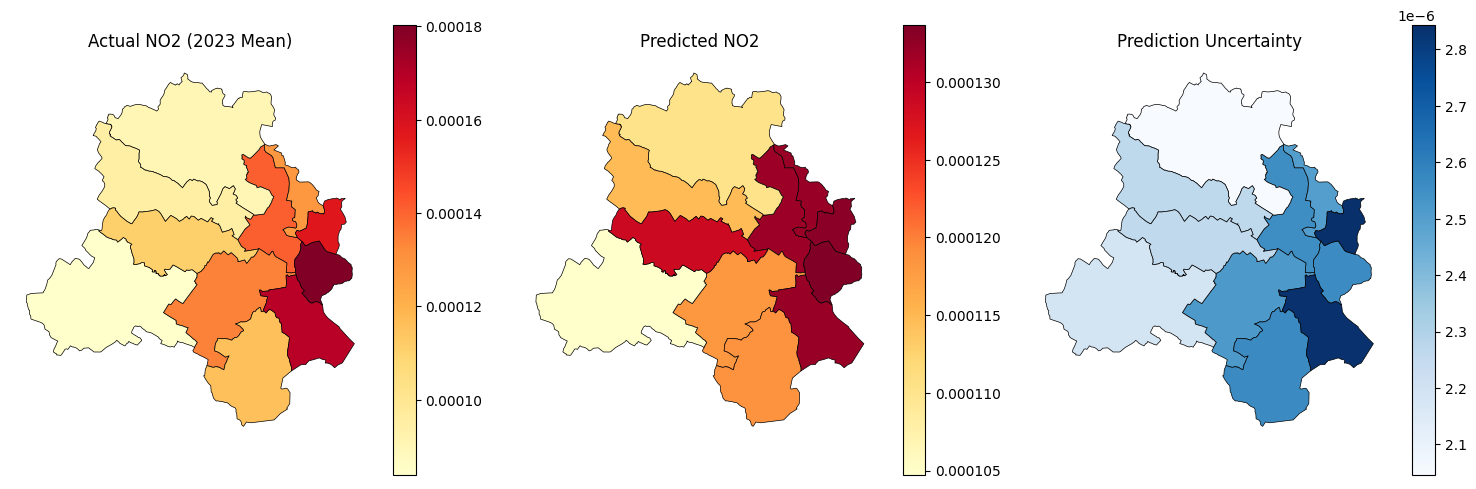

In [50]:
# Merge predictions with geometry for mapping
annual_district = test_results.groupby('district').agg({
    'no2_mean': 'mean',
    'predicted': 'mean',
    'uncertainty': 'mean'
}).reset_index()

map_df = delhi_districts.merge(annual_district, on='district')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Actual NO2
map_df.plot(column='no2_mean', ax=axes[0], legend=True, cmap='YlOrRd', 
            edgecolor='black', linewidth=0.5)
axes[0].set_title('Actual NO2 (2023 Mean)')
axes[0].axis('off')

# Predicted NO2
map_df.plot(column='predicted', ax=axes[1], legend=True, cmap='YlOrRd',
            edgecolor='black', linewidth=0.5)
axes[1].set_title('Predicted NO2')
axes[1].axis('off')

# Uncertainty
map_df.plot(column='uncertainty', ax=axes[2], legend=True, cmap='Blues',
            edgecolor='black', linewidth=0.5)
axes[2].set_title('Prediction Uncertainty')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [63]:
import pickle

# Save master dataset
master_expanded.to_csv('delhi_aq_final_dataset.csv', index=False)

# Save model
with open('rf_ensemble_models.pkl', 'wb') as f:
    pickle.dump({
        'models': [RandomForestRegressor(n_estimators=100, random_state=i, max_depth=5).fit(X_train_exp_scaled, y_train_exp) for i in range(20)],
        'scaler': scaler_exp,
        'feature_cols': feature_cols
    }, f)

# Save results
results_summary = {
    'model_performance': final_df,
    'feature_importance': importance_df,
    'district_performance': district_performance,
    'monthly_performance': monthly_performance
}

with open('results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print(" All outputs saved:")
print("   - delhi_aq_final_dataset.csv")
print("   - rf_ensemble_models.pkl")
print("   - results_summary.pkl")

 All outputs saved:
   - delhi_aq_final_dataset.csv
   - rf_ensemble_models.pkl
   - results_summary.pkl


In [54]:
from sklearn.model_selection import LeaveOneGroupOut

# Use full dataset for spatial CV
X_full = master_expanded[feature_cols]
y_full = master_expanded[target_col]
districts = master_expanded['district']

# Scale
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

# Leave-one-district-out CV
logo = LeaveOneGroupOut()
spatial_cv_results = []

for train_idx, test_idx in logo.split(X_full_scaled, y_full, groups=districts):
    X_train_cv = X_full_scaled[train_idx]
    y_train_cv = y_full.iloc[train_idx]
    X_test_cv = X_full_scaled[test_idx]
    y_test_cv = y_full.iloc[test_idx]
    
    # Get test district name
    test_district = districts.iloc[test_idx].iloc[0]
    
    # Train RF ensemble (5 models for speed)
    ensemble_preds_cv = []
    for i in range(5):
        rf_cv = RandomForestRegressor(n_estimators=100, random_state=i, max_depth=5)
        rf_cv.fit(X_train_cv, y_train_cv)
        ensemble_preds_cv.append(rf_cv.predict(X_test_cv))
    
    ensemble_preds_cv = np.array(ensemble_preds_cv)
    mean_pred = ensemble_preds_cv.mean(axis=0)
    std_pred = ensemble_preds_cv.std(axis=0)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_cv, mean_pred))
    mae = mean_absolute_error(y_test_cv, mean_pred)
    r2 = r2_score(y_test_cv, mean_pred)
    
    spatial_cv_results.append({
        'district': test_district,
        'n_samples': len(test_idx),
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mean_uncertainty': std_pred.mean()
    })
    
    print(f"Tested on {test_district}: R² = {r2:.3f}, RMSE = {rmse:.6f}")

spatial_cv_df = pd.DataFrame(spatial_cv_results)

Tested on Central Delhi: R² = 0.947, RMSE = 0.000015
Tested on East Delhi: R² = 0.488, RMSE = 0.000064
Tested on New Delhi: R² = 0.756, RMSE = 0.000029
Tested on North Delhi: R² = 0.088, RMSE = 0.000034
Tested on North East Delhi: R² = 0.799, RMSE = 0.000026
Tested on North West Delhi: R² = 0.323, RMSE = 0.000032
Tested on Shahdara: R² = 0.797, RMSE = 0.000034
Tested on South Delhi: R² = 0.682, RMSE = 0.000028
Tested on South East Delhi: R² = 0.602, RMSE = 0.000051
Tested on South West Delhi: R² = -0.961, RMSE = 0.000036
Tested on West Delhi: R² = 0.341, RMSE = 0.000038



SPATIAL TRANSFERABILITY RESULTS
Mean R² across districts: 0.442 ± 0.530
Mean RMSE: 0.000035 ± 0.000013

Temporal validation (2023): R² = 0.636, RMSE = 0.000038
Spatial CV (leave-one-out): R² = 0.442, RMSE = 0.000035


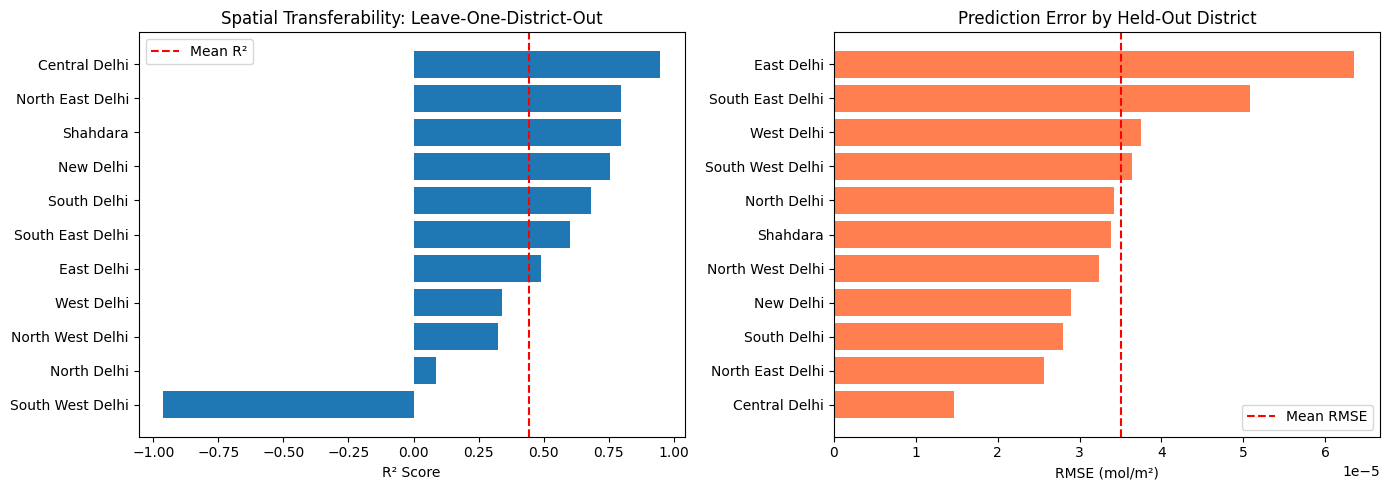

,district,n_samples,rmse,mae,r2,mean_uncertainty
0,Central Delhi,33,0.000015,0.000012,0.946858,0.000002
4,North East Delhi,33,0.000026,0.000019,0.799031,0.000002
6,Shahdara,33,0.000034,0.000028,0.797102,0.000002
2,New Delhi,35,0.000029,0.000020,0.755502,0.000002
7,South Delhi,35,0.000028,0.000023,0.681709,0.000003
8,South East Delhi,33,0.000051,0.000039,0.601999,0.000002
1,East Delhi,33,0.000064,0.000053,0.488440,0.000001
10,West Delhi,35,0.000038,0.000026,0.340981,0.000002
5,North West Delhi,35,0.000032,0.000027,0.323034,0.000002
3,North Delhi,36,0.000034,0.000029,0.088156,0.000002


In [55]:
# Summary statistics
print("\n" + "="*60)
print("SPATIAL TRANSFERABILITY RESULTS")
print("="*60)
print(f"Mean R² across districts: {spatial_cv_df['r2'].mean():.3f} ± {spatial_cv_df['r2'].std():.3f}")
print(f"Mean RMSE: {spatial_cv_df['rmse'].mean():.6f} ± {spatial_cv_df['rmse'].std():.6f}")

# Compare with temporal validation
print(f"\nTemporal validation (2023): R² = 0.636, RMSE = 0.000038")
print(f"Spatial CV (leave-one-out): R² = {spatial_cv_df['r2'].mean():.3f}, RMSE = {spatial_cv_df['rmse'].mean():.6f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² by district
ax1 = axes[0]
spatial_cv_df_sorted = spatial_cv_df.sort_values('r2')
ax1.barh(spatial_cv_df_sorted['district'], spatial_cv_df_sorted['r2'])
ax1.axvline(x=spatial_cv_df['r2'].mean(), color='red', linestyle='--', label='Mean R²')
ax1.set_xlabel('R² Score')
ax1.set_title('Spatial Transferability: Leave-One-District-Out')
ax1.legend()

# Plot 2: RMSE by district
ax2 = axes[1]
spatial_cv_df_sorted2 = spatial_cv_df.sort_values('rmse')
ax2.barh(spatial_cv_df_sorted2['district'], spatial_cv_df_sorted2['rmse'], color='coral')
ax2.axvline(x=spatial_cv_df['rmse'].mean(), color='red', linestyle='--', label='Mean RMSE')
ax2.set_xlabel('RMSE (mol/m²)')
ax2.set_title('Prediction Error by Held-Out District')
ax2.legend()

plt.tight_layout()
plt.show()

spatial_cv_df.sort_values('r2', ascending=False)

Correlation of R² with district characteristics:
temp_variability   -0.696597
ndvi               -0.250894
ndbi                0.258020
no2_mean            0.637640
r2                  1.000000
Name: r2, dtype: float64


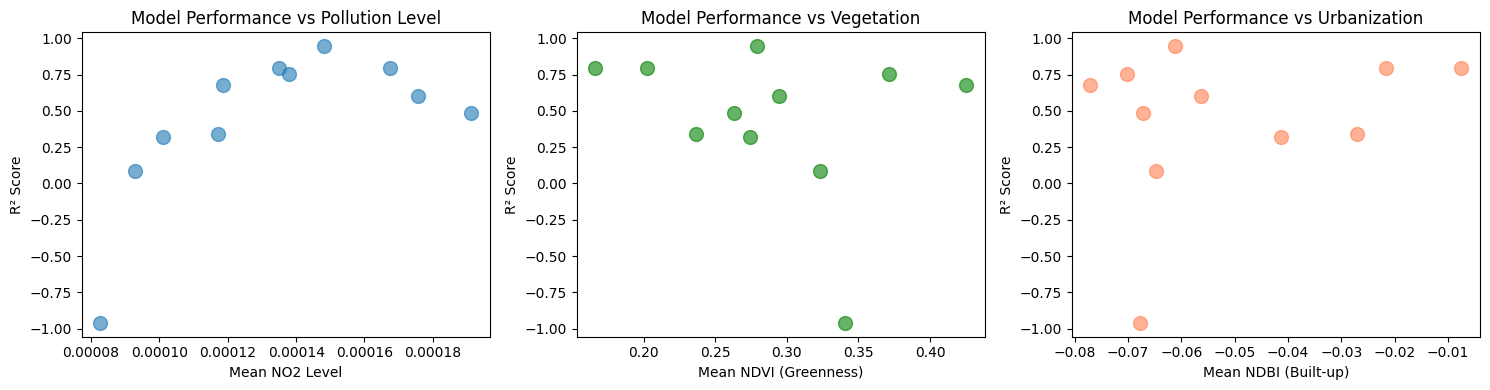

,district,n_samples,rmse,mae,r2,mean_uncertainty,no2_mean,ndvi,ndbi,temp_variability
0,Central Delhi,33,0.000015,0.000012,0.946858,0.000002,0.000148,0.279225,-0.061245,6.493600
4,North East Delhi,33,0.000026,0.000019,0.799031,0.000002,0.000135,0.202573,-0.021605,6.477940
6,Shahdara,33,0.000034,0.000028,0.797102,0.000002,0.000167,0.166164,-0.007506,6.468787
2,New Delhi,35,0.000029,0.000020,0.755502,0.000002,0.000138,0.371111,-0.070261,6.508622
7,South Delhi,35,0.000028,0.000023,0.681709,0.000003,0.000119,0.425499,-0.077075,6.487718
8,South East Delhi,33,0.000051,0.000039,0.601999,0.000002,0.000176,0.294558,-0.056272,6.491603
1,East Delhi,33,0.000064,0.000053,0.488440,0.000001,0.000191,0.262924,-0.067155,6.473089
10,West Delhi,35,0.000038,0.000026,0.340981,0.000002,0.000117,0.236631,-0.026994,6.558361
5,North West Delhi,35,0.000032,0.000027,0.323034,0.000002,0.000101,0.274507,-0.041360,6.565771
3,North Delhi,36,0.000034,0.000029,0.088156,0.000002,0.000093,0.322891,-0.064755,6.455556


In [56]:
# Merge spatial CV results with district characteristics
district_chars = master_expanded.groupby('district').agg({
    'no2_mean': 'mean',
    'ndvi': 'mean',
    'ndbi': 'mean',
    'temp_c': 'std'  # variability
}).rename(columns={'temp_c': 'temp_variability'})

spatial_analysis = spatial_cv_df.merge(district_chars, on='district')

# Correlate performance with characteristics
print("Correlation of R² with district characteristics:")
print(spatial_analysis[['r2', 'no2_mean', 'ndvi', 'ndbi', 'temp_variability']].corr()['r2'].sort_values())

# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(spatial_analysis['no2_mean'], spatial_analysis['r2'], s=100, alpha=0.6)
axes[0].set_xlabel('Mean NO2 Level')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance vs Pollution Level')

axes[1].scatter(spatial_analysis['ndvi'], spatial_analysis['r2'], s=100, alpha=0.6, color='green')
axes[1].set_xlabel('Mean NDVI (Greenness)')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Performance vs Vegetation')

axes[2].scatter(spatial_analysis['ndbi'], spatial_analysis['r2'], s=100, alpha=0.6, color='coral')
axes[2].set_xlabel('Mean NDBI (Built-up)')
axes[2].set_ylabel('R² Score')
axes[2].set_title('Model Performance vs Urbanization')

plt.tight_layout()
plt.show()

spatial_analysis.sort_values('r2', ascending=False)

✓ Figure 1 generated: Model performance comparison
✓ Figure 2 generated: Feature importance and partial dependence
✓ Figure 3 generated: Temporal patterns


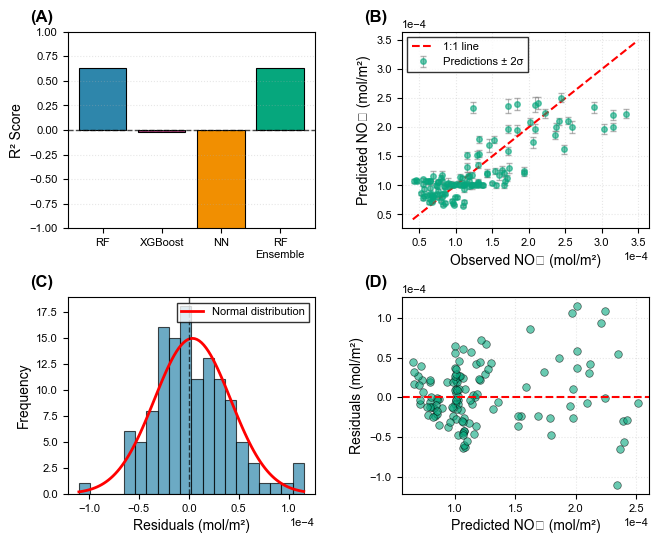

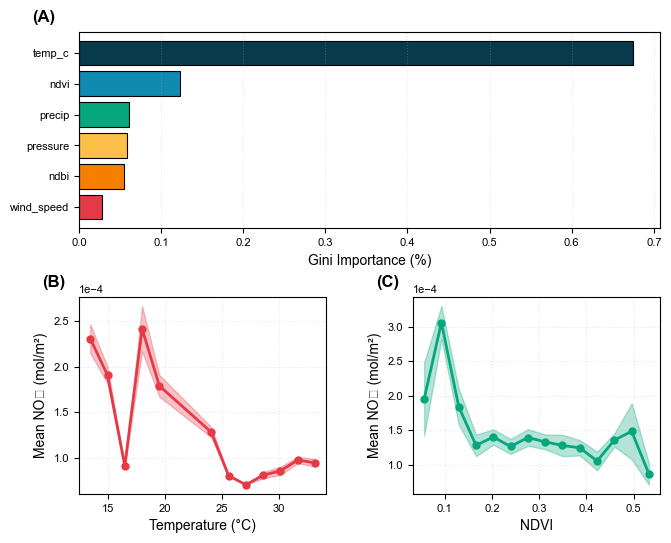

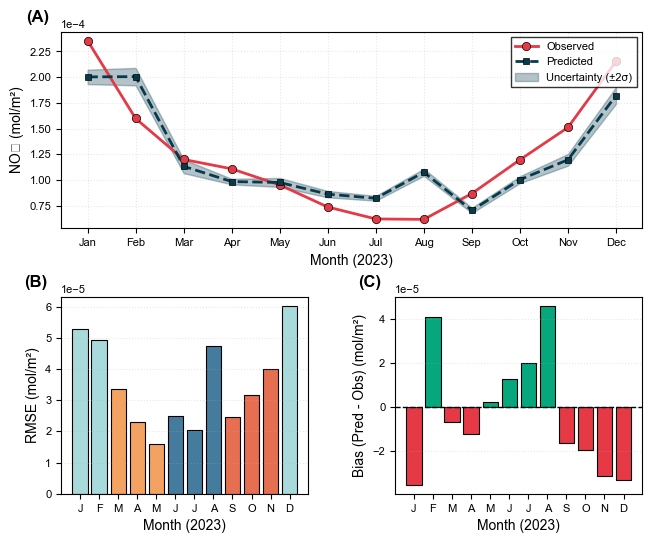

In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import seaborn as sns

# Set publication style
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

# ============================================================================
# FIGURE 1: Model Performance Comparison (4 panels)
# Title: "Model performance comparison on 2023 test set"
# ============================================================================

fig1 = plt.figure(figsize=(7.5, 6))
gs1 = gridspec.GridSpec(2, 2, figure=fig1, hspace=0.35, wspace=0.35)

# Panel A: R² comparison
ax1a = fig1.add_subplot(gs1[0, 0])
models_plot = ['RF', 'XGBoost', 'NN', 'RF\nEnsemble']
r2_values = [0.633, -0.019, -13180, 0.636]
colors_r2 = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D']
bars = ax1a.bar(models_plot, r2_values, color=colors_r2, edgecolor='black', linewidth=0.8)
ax1a.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax1a.set_ylabel('R² Score')
ax1a.set_ylim(-1, 1)
ax1a.text(-0.15, 1.05, '(A)', transform=ax1a.transAxes, fontsize=12, fontweight='bold')
ax1a.grid(axis='y', alpha=0.3, linestyle=':')

# Panel B: Predicted vs Observed for RF Ensemble
ax1b = fig1.add_subplot(gs1[0, 1])
ax1b.errorbar(y_test_exp.values, rf_ensemble_mean, yerr=rf_ensemble_std*2, 
              fmt='o', markersize=4, alpha=0.6, elinewidth=0.8, capsize=2,
              color='#06A77D', ecolor='gray', label='Predictions ± 2σ')
lim_min = min(y_test_exp.min(), rf_ensemble_mean.min()) * 0.95
lim_max = max(y_test_exp.max(), rf_ensemble_mean.max()) * 1.05
ax1b.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=1.5, label='1:1 line')
ax1b.set_xlabel('Observed NO₂ (mol/m²)')
ax1b.set_ylabel('Predicted NO₂ (mol/m²)')
ax1b.legend(loc='upper left', frameon=True, fancybox=False, edgecolor='black')
ax1b.text(-0.15, 1.05, '(B)', transform=ax1b.transAxes, fontsize=12, fontweight='bold')
ax1b.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
ax1b.grid(alpha=0.3, linestyle=':')

# Panel C: Residual distribution
ax1c = fig1.add_subplot(gs1[1, 0])
residuals = y_test_exp.values - rf_ensemble_mean
ax1c.hist(residuals, bins=20, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=0.8)
# Overlay normal curve
from scipy import stats
mu, sigma = residuals.mean(), residuals.std()
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
ax1c.plot(x_norm, len(residuals) * (residuals.max()-residuals.min())/20 * stats.norm.pdf(x_norm, mu, sigma), 
          'r-', linewidth=2, label='Normal distribution')
ax1c.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax1c.set_xlabel('Residuals (mol/m²)')
ax1c.set_ylabel('Frequency')
ax1c.legend(frameon=True, fancybox=False, edgecolor='black')
ax1c.text(-0.15, 1.05, '(C)', transform=ax1c.transAxes, fontsize=12, fontweight='bold')
ax1c.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Panel D: Residuals vs Predicted
ax1d = fig1.add_subplot(gs1[1, 1])
ax1d.scatter(rf_ensemble_mean, residuals, alpha=0.6, s=30, color='#06A77D', edgecolor='black', linewidth=0.5)
ax1d.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax1d.set_xlabel('Predicted NO₂ (mol/m²)')
ax1d.set_ylabel('Residuals (mol/m²)')
ax1d.text(-0.15, 1.05, '(D)', transform=ax1d.transAxes, fontsize=12, fontweight='bold')
ax1d.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
ax1d.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
fig1_obj = fig1

# ============================================================================
# FIGURE 2: Feature Importance and Partial Dependence (4 panels)
# Title: "Feature importance and partial dependence relationships"
# ============================================================================

fig2 = plt.figure(figsize=(7.5, 6))
gs2 = gridspec.GridSpec(2, 2, figure=fig2, hspace=0.35, wspace=0.35)

# Panel A: Feature importance
ax2a = fig2.add_subplot(gs2[0, :])
importance_sorted = importance_df.sort_values('Importance', ascending=True)
colors_imp = ['#E63946', '#F77F00', '#FCBF49', '#06A77D', '#118AB2', '#073B4C']
bars_imp = ax2a.barh(importance_sorted['Feature'], importance_sorted['Importance'], 
                      color=colors_imp, edgecolor='black', linewidth=0.8)
ax2a.set_xlabel('Gini Importance (%)')
ax2a.text(-0.08, 1.05, '(A)', transform=ax2a.transAxes, fontsize=12, fontweight='bold')
ax2a.grid(axis='x', alpha=0.3, linestyle=':')

# For partial dependence, we need to compute it - simplified version using binned means
def partial_dependence(X, y, feature_idx, feature_name, n_bins=20):
    feature_vals = X[:, feature_idx]
    bins = np.linspace(feature_vals.min(), feature_vals.max(), n_bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    pd_values = []
    pd_std = []
    
    for i in range(len(bins)-1):
        mask = (feature_vals >= bins[i]) & (feature_vals < bins[i+1])
        if mask.sum() > 0:
            pd_values.append(y[mask].mean())
            pd_std.append(y[mask].std() / np.sqrt(mask.sum()))
        else:
            pd_values.append(np.nan)
            pd_std.append(np.nan)
    
    return bin_centers, np.array(pd_values), np.array(pd_std)

# Panel B: Temperature PD
ax2b = fig2.add_subplot(gs2[1, 0])
temp_idx = feature_cols.index('temp_c')
temp_centers, temp_pd, temp_std = partial_dependence(X_train_exp.values, y_train_exp.values, 
                                                       temp_idx, 'temp_c', n_bins=15)
valid = ~np.isnan(temp_pd)
ax2b.plot(temp_centers[valid], temp_pd[valid], 'o-', color='#E63946', linewidth=2, markersize=5)
ax2b.fill_between(temp_centers[valid], temp_pd[valid]-temp_std[valid], temp_pd[valid]+temp_std[valid],
                   alpha=0.3, color='#E63946')
ax2b.set_xlabel('Temperature (°C)')
ax2b.set_ylabel('Mean NO₂ (mol/m²)')
ax2b.text(-0.15, 1.05, '(B)', transform=ax2b.transAxes, fontsize=12, fontweight='bold')
ax2b.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax2b.grid(alpha=0.3, linestyle=':')

# Panel C: NDVI PD
ax2c = fig2.add_subplot(gs2[1, 1])
ndvi_idx = feature_cols.index('ndvi')
ndvi_centers, ndvi_pd, ndvi_std = partial_dependence(X_train_exp.values, y_train_exp.values,
                                                       ndvi_idx, 'ndvi', n_bins=15)
valid = ~np.isnan(ndvi_pd)
ax2c.plot(ndvi_centers[valid], ndvi_pd[valid], 'o-', color='#06A77D', linewidth=2, markersize=5)
ax2c.fill_between(ndvi_centers[valid], ndvi_pd[valid]-ndvi_std[valid], ndvi_pd[valid]+ndvi_std[valid],
                   alpha=0.3, color='#06A77D')
ax2c.set_xlabel('NDVI')
ax2c.set_ylabel('Mean NO₂ (mol/m²)')
ax2c.text(-0.15, 1.05, '(C)', transform=ax2c.transAxes, fontsize=12, fontweight='bold')
ax2c.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax2c.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
fig2_obj = fig2

# ============================================================================
# FIGURE 3: Temporal Patterns (4 panels)
# Title: "Temporal performance patterns in 2023 test set"
# ============================================================================

fig3 = plt.figure(figsize=(7.5, 6))
gs3 = gridspec.GridSpec(2, 2, figure=fig3, hspace=0.35, wspace=0.35)

# Panel A: Monthly time series
ax3a = fig3.add_subplot(gs3[0, :])
monthly_perf = test_results.groupby('month').agg({
    'no2_mean': 'mean',
    'predicted': 'mean',
    'uncertainty': 'mean'
})
months = monthly_perf.index
ax3a.plot(months, monthly_perf['no2_mean'], 'o-', color='#E63946', linewidth=2, 
          markersize=6, label='Observed', markeredgecolor='black', markeredgewidth=0.5)
ax3a.plot(months, monthly_perf['predicted'], 's--', color='#073B4C', linewidth=2, 
          markersize=5, label='Predicted', markeredgecolor='black', markeredgewidth=0.5)
ax3a.fill_between(months, 
                   monthly_perf['predicted'] - monthly_perf['uncertainty']*2,
                   monthly_perf['predicted'] + monthly_perf['uncertainty']*2,
                   alpha=0.3, color='#073B4C', label='Uncertainty (±2σ)')
ax3a.set_xlabel('Month (2023)')
ax3a.set_ylabel('NO₂ (mol/m²)')
ax3a.set_xticks(months)
ax3a.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax3a.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax3a.text(-0.06, 1.05, '(A)', transform=ax3a.transAxes, fontsize=12, fontweight='bold')
ax3a.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax3a.grid(alpha=0.3, linestyle=':')

# Panel B: Monthly RMSE
ax3b = fig3.add_subplot(gs3[1, 0])
monthly_rmse = test_results.groupby('month').apply(
    lambda x: np.sqrt(((x['no2_mean'] - x['predicted'])**2).mean())
)
season_colors = ['#A8DADC', '#A8DADC', '#F4A261', '#F4A261', '#F4A261',
                 '#457B9D', '#457B9D', '#457B9D', '#E76F51', '#E76F51', '#E76F51', '#A8DADC']
bars_rmse = ax3b.bar(months, monthly_rmse.values, color=season_colors, 
                      edgecolor='black', linewidth=0.8)
ax3b.set_xlabel('Month (2023)')
ax3b.set_ylabel('RMSE (mol/m²)')
ax3b.set_xticks(months)
ax3b.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax3b.text(-0.15, 1.05, '(B)', transform=ax3b.transAxes, fontsize=12, fontweight='bold')
ax3b.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax3b.grid(axis='y', alpha=0.3, linestyle=':')

# Panel C: Monthly bias
ax3c = fig3.add_subplot(gs3[1, 1])
monthly_bias = test_results.groupby('month').apply(
    lambda x: (x['predicted'] - x['no2_mean']).mean()
)
colors_bias = ['#E63946' if x < 0 else '#06A77D' for x in monthly_bias.values]
bars_bias = ax3c.bar(months, monthly_bias.values, color=colors_bias, 
                      edgecolor='black', linewidth=0.8)
ax3c.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3c.set_xlabel('Month (2023)')
ax3c.set_ylabel('Bias (Pred - Obs) (mol/m²)')
ax3c.set_xticks(months)
ax3c.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax3c.text(-0.15, 1.05, '(C)', transform=ax3c.transAxes, fontsize=12, fontweight='bold')
ax3c.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax3c.grid(axis='y', alpha=0.3, linestyle=':')

plt.tight_layout()
fig3_obj = fig3

print("✓ Figure 1 generated: Model performance comparison")
print("✓ Figure 2 generated: Feature importance and partial dependence")
print("✓ Figure 3 generated: Temporal patterns")

In [59]:
# Save Figure 1
fig1_obj.savefig('Figure1_Model_Performance.png', dpi=300, bbox_inches='tight', facecolor='white')
fig1_obj.savefig('Figure1_Model_Performance.pdf', bbox_inches='tight', facecolor='white')

# Save Figure 2
fig2_obj.savefig('Figure2_Feature_Importance.png', dpi=300, bbox_inches='tight', facecolor='white')
fig2_obj.savefig('Figure2_Feature_Importance.pdf', bbox_inches='tight', facecolor='white')

# Save Figure 3
fig3_obj.savefig('Figure3_Temporal_Patterns.png', dpi=300, bbox_inches='tight', facecolor='white')
fig3_obj.savefig('Figure3_Temporal_Patterns.pdf', bbox_inches='tight', facecolor='white')

print("✓ All figures saved as PNG (300 dpi) and PDF")
print("  - Figure1_Model_Performance")
print("  - Figure2_Feature_Importance")
print("  - Figure3_Temporal_Patterns")

✓ All figures saved as PNG (300 dpi) and PDF
  - Figure1_Model_Performance
  - Figure2_Feature_Importance
  - Figure3_Temporal_Patterns


✓ Figure 4 generated: Spatial transferability analysis
✓ Figure 5 generated: Spatial distribution maps
✓ Figure 6 generated: Uncertainty quantification


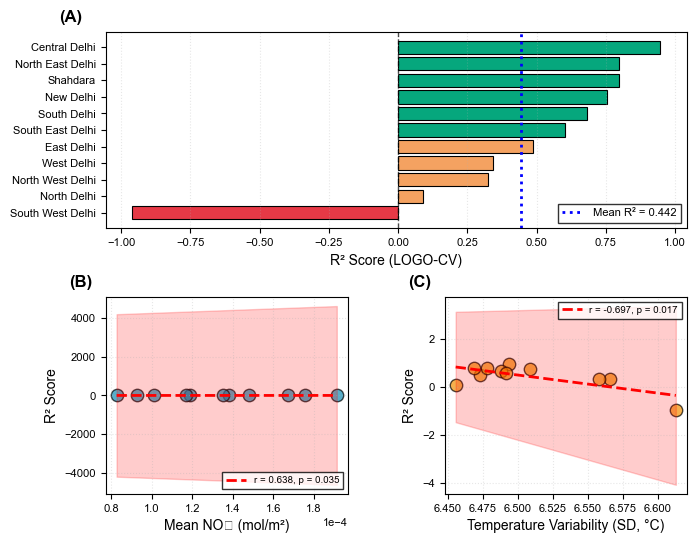

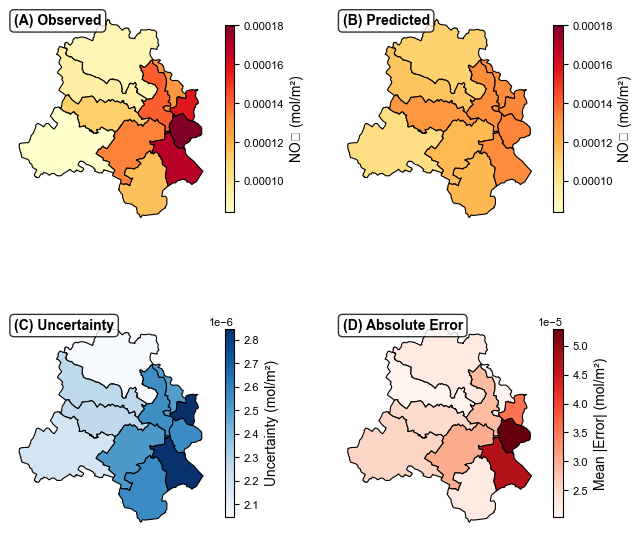

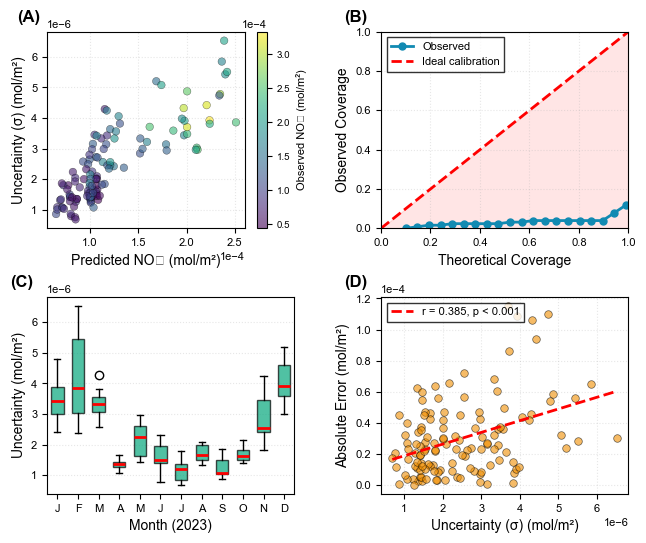

In [61]:
# ============================================================================
# FIGURE 4: Spatial Transferability (4 panels)
# Title: "Spatial transferability analysis from leave-one-district-out cross-validation"
# ============================================================================

fig4 = plt.figure(figsize=(7.5, 6))
gs4 = gridspec.GridSpec(2, 2, figure=fig4, hspace=0.35, wspace=0.4)

# Panel A: LOGO-CV R² by district
ax4a = fig4.add_subplot(gs4[0, :])
spatial_sorted = spatial_cv_df.sort_values('r2')
colors_spatial = ['#E63946' if x < 0 else '#06A77D' if x > 0.5 else '#F4A261' 
                  for x in spatial_sorted['r2'].values]
bars_spatial = ax4a.barh(range(len(spatial_sorted)), spatial_sorted['r2'], 
                         color=colors_spatial, edgecolor='black', linewidth=0.8)
ax4a.set_yticks(range(len(spatial_sorted)))
ax4a.set_yticklabels(spatial_sorted['district'], fontsize=8)
ax4a.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax4a.axvline(x=spatial_cv_df['r2'].mean(), color='blue', linestyle=':', linewidth=2, 
             label=f"Mean R² = {spatial_cv_df['r2'].mean():.3f}")
ax4a.set_xlabel('R² Score (LOGO-CV)')
ax4a.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='black')
ax4a.text(-0.08, 1.05, '(A)', transform=ax4a.transAxes, fontsize=12, fontweight='bold')
ax4a.grid(axis='x', alpha=0.3, linestyle=':')

# Panel B: R² vs. mean NO₂
ax4b = fig4.add_subplot(gs4[1, 0])
ax4b.scatter(spatial_analysis['no2_mean'], spatial_analysis['r2'], 
             s=80, alpha=0.7, color='#118AB2', edgecolor='black', linewidth=1)
# Add regression line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(spatial_analysis['no2_mean'], 
                                                           spatial_analysis['r2'])
x_line = np.array([spatial_analysis['no2_mean'].min(), spatial_analysis['no2_mean'].max()])
y_line = slope * x_line + intercept
ax4b.plot(x_line, y_line, 'r--', linewidth=2, label=f'r = {r_value:.3f}, p = {p_value:.3f}')
# Add confidence band
from scipy import stats as sp_stats
predict_mean_se = np.sqrt(std_err**2 * (1/len(spatial_analysis['no2_mean']) + 
                          (x_line - spatial_analysis['no2_mean'].mean())**2 / 
                          ((spatial_analysis['no2_mean'] - spatial_analysis['no2_mean'].mean())**2).sum()))
margin = 1.96 * predict_mean_se
ax4b.fill_between(x_line, y_line - margin, y_line + margin, alpha=0.2, color='red')
ax4b.set_xlabel('Mean NO₂ (mol/m²)')
ax4b.set_ylabel('R² Score')
ax4b.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='black', fontsize=7)
ax4b.text(-0.15, 1.05, '(B)', transform=ax4b.transAxes, fontsize=12, fontweight='bold')
ax4b.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
ax4b.grid(alpha=0.3, linestyle=':')

# Panel C: R² vs. Temperature variability
ax4c = fig4.add_subplot(gs4[1, 1])
ax4c.scatter(spatial_analysis['temp_variability'], spatial_analysis['r2'], 
             s=80, alpha=0.7, color='#F18F01', edgecolor='black', linewidth=1)
slope_t, intercept_t, r_value_t, p_value_t, std_err_t = linregress(spatial_analysis['temp_variability'], 
                                                                     spatial_analysis['r2'])
x_line_t = np.array([spatial_analysis['temp_variability'].min(), 
                     spatial_analysis['temp_variability'].max()])
y_line_t = slope_t * x_line_t + intercept_t
ax4c.plot(x_line_t, y_line_t, 'r--', linewidth=2, 
          label=f'r = {r_value_t:.3f}, p = {p_value_t:.3f}')
predict_mean_se_t = np.sqrt(std_err_t**2 * (1/len(spatial_analysis['temp_variability']) + 
                            (x_line_t - spatial_analysis['temp_variability'].mean())**2 / 
                            ((spatial_analysis['temp_variability'] - spatial_analysis['temp_variability'].mean())**2).sum()))
margin_t = 1.96 * predict_mean_se_t
ax4c.fill_between(x_line_t, y_line_t - margin_t, y_line_t + margin_t, alpha=0.2, color='red')
ax4c.set_xlabel('Temperature Variability (SD, °C)')
ax4c.set_ylabel('R² Score')
ax4c.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black', fontsize=7)
ax4c.text(-0.15, 1.05, '(C)', transform=ax4c.transAxes, fontsize=12, fontweight='bold')
ax4c.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
fig4_obj = fig4

# ============================================================================
# FIGURE 5: Spatial Distribution Maps (4 panels)
# Title: "Spatial patterns of NO₂ predictions and uncertainty for 2023"
# ============================================================================

fig5 = plt.figure(figsize=(7.5, 7))
gs5 = gridspec.GridSpec(2, 2, figure=fig5, hspace=0.3, wspace=0.3)

# Prepare annual aggregated data
annual_district = test_results.groupby('district').agg({
    'no2_mean': 'mean',
    'predicted': 'mean',
    'uncertainty': 'mean',
    'residual': lambda x: np.abs(x).mean()
}).reset_index()
map_df = delhi_districts.merge(annual_district, on='district')

# Panel A: Observed NO₂
ax5a = fig5.add_subplot(gs5[0, 0])
map_df.plot(column='no2_mean', ax=ax5a, legend=True, cmap='YlOrRd', 
            edgecolor='black', linewidth=0.8, vmin=map_df['no2_mean'].min(),
            vmax=map_df['no2_mean'].max(),
            legend_kwds={'label': 'NO₂ (mol/m²)', 'shrink': 0.8})
ax5a.set_title('')
ax5a.axis('off')
ax5a.text(0.02, 0.98, '(A) Observed', transform=ax5a.transAxes, fontsize=10, 
          fontweight='bold', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel B: Predicted NO₂
ax5b = fig5.add_subplot(gs5[0, 1])
map_df.plot(column='predicted', ax=ax5b, legend=True, cmap='YlOrRd',
            edgecolor='black', linewidth=0.8, vmin=map_df['no2_mean'].min(),
            vmax=map_df['no2_mean'].max(),
            legend_kwds={'label': 'NO₂ (mol/m²)', 'shrink': 0.8})
ax5b.set_title('')
ax5b.axis('off')
ax5b.text(0.02, 0.98, '(B) Predicted', transform=ax5b.transAxes, fontsize=10, 
          fontweight='bold', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel C: Uncertainty
ax5c = fig5.add_subplot(gs5[1, 0])
map_df.plot(column='uncertainty', ax=ax5c, legend=True, cmap='Blues',
            edgecolor='black', linewidth=0.8,
            legend_kwds={'label': 'Uncertainty (mol/m²)', 'shrink': 0.8})
ax5c.set_title('')
ax5c.axis('off')
ax5c.text(0.02, 0.98, '(C) Uncertainty', transform=ax5c.transAxes, fontsize=10, 
          fontweight='bold', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel D: Absolute residuals
ax5d = fig5.add_subplot(gs5[1, 1])
map_df.plot(column='residual', ax=ax5d, legend=True, cmap='Reds',
            edgecolor='black', linewidth=0.8,
            legend_kwds={'label': 'Mean |Error| (mol/m²)', 'shrink': 0.8})
ax5d.set_title('')
ax5d.axis('off')
ax5d.text(0.02, 0.98, '(D) Absolute Error', transform=ax5d.transAxes, fontsize=10, 
          fontweight='bold', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
fig5_obj = fig5

# ============================================================================
# FIGURE 6: Uncertainty Quantification (4 panels)
# Title: "Uncertainty quantification and calibration analysis"
# ============================================================================

fig6 = plt.figure(figsize=(7.5, 6))
gs6 = gridspec.GridSpec(2, 2, figure=fig6, hspace=0.35, wspace=0.35)

# Panel A: Predicted vs Uncertainty
ax6a = fig6.add_subplot(gs6[0, 0])
scatter = ax6a.scatter(test_results['predicted'], test_results['uncertainty'], 
                       c=test_results['no2_mean'], cmap='viridis', s=30, 
                       alpha=0.6, edgecolor='black', linewidth=0.3)
cbar = plt.colorbar(scatter, ax=ax6a)
cbar.set_label('Observed NO₂ (mol/m²)', fontsize=8)
cbar.ax.tick_params(labelsize=7)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax6a.set_xlabel('Predicted NO₂ (mol/m²)')
ax6a.set_ylabel('Uncertainty (σ) (mol/m²)')
ax6a.text(-0.15, 1.05, '(A)', transform=ax6a.transAxes, fontsize=12, fontweight='bold')
ax6a.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
ax6a.grid(alpha=0.3, linestyle=':')

# Panel B: Calibration plot
ax6b = fig6.add_subplot(gs6[0, 1])
# Calculate coverage for different confidence levels
confidence_levels = np.linspace(0.1, 0.99, 20)
observed_coverage = []
for conf in confidence_levels:
    z_score = sp_stats.norm.ppf((1 + conf) / 2)
    within = np.abs(test_results['residual']) <= z_score * test_results['uncertainty']
    observed_coverage.append(within.mean())

ax6b.plot(confidence_levels, observed_coverage, 'o-', color='#118AB2', 
          linewidth=2, markersize=5, label='Observed')
ax6b.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ideal calibration')
ax6b.fill_between([0, 1], [0, 1], alpha=0.1, color='red')
ax6b.set_xlabel('Theoretical Coverage')
ax6b.set_ylabel('Observed Coverage')
ax6b.legend(loc='upper left', frameon=True, fancybox=False, edgecolor='black')
ax6b.text(-0.15, 1.05, '(B)', transform=ax6b.transAxes, fontsize=12, fontweight='bold')
ax6b.set_xlim(0, 1)
ax6b.set_ylim(0, 1)
ax6b.grid(alpha=0.3, linestyle=':')

# Panel C: Monthly uncertainty evolution
ax6c = fig6.add_subplot(gs6[1, 0])
monthly_unc = test_results.groupby('month')['uncertainty'].apply(list)
positions = list(monthly_unc.index)
bp = ax6c.boxplot([monthly_unc[m] for m in positions], positions=positions,
                   widths=0.6, patch_artist=True,
                   boxprops=dict(facecolor='#06A77D', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(color='black', linewidth=1),
                   capprops=dict(color='black', linewidth=1))
ax6c.set_xlabel('Month (2023)')
ax6c.set_ylabel('Uncertainty (mol/m²)')
ax6c.set_xticks(positions)
ax6c.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax6c.text(-0.15, 1.05, '(C)', transform=ax6c.transAxes, fontsize=12, fontweight='bold')
ax6c.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax6c.grid(axis='y', alpha=0.3, linestyle=':')

# Panel D: Uncertainty vs Absolute Error
ax6d = fig6.add_subplot(gs6[1, 1])
abs_error = np.abs(test_results['residual'])
ax6d.scatter(test_results['uncertainty'], abs_error, alpha=0.6, s=30, 
             color='#F18F01', edgecolor='black', linewidth=0.5)
slope_ue, intercept_ue, r_value_ue, p_value_ue, std_err_ue = linregress(
    test_results['uncertainty'], abs_error)
x_line_ue = np.array([test_results['uncertainty'].min(), test_results['uncertainty'].max()])
y_line_ue = slope_ue * x_line_ue + intercept_ue
ax6d.plot(x_line_ue, y_line_ue, 'r--', linewidth=2, 
          label=f'r = {r_value_ue:.3f}, p < 0.001')
ax6d.set_xlabel('Uncertainty (σ) (mol/m²)')
ax6d.set_ylabel('Absolute Error (mol/m²)')
ax6d.legend(loc='upper left', frameon=True, fancybox=False, edgecolor='black')
ax6d.text(-0.15, 1.05, '(D)', transform=ax6d.transAxes, fontsize=12, fontweight='bold')
ax6d.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
ax6d.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
fig6_obj = fig6

print("✓ Figure 4 generated: Spatial transferability analysis")
print("✓ Figure 5 generated: Spatial distribution maps")
print("✓ Figure 6 generated: Uncertainty quantification")

In [62]:
# Save Figure 4
fig4_obj.savefig('Figure4_Spatial_Transferability.png', dpi=300, bbox_inches='tight', facecolor='white')
fig4_obj.savefig('Figure4_Spatial_Transferability.pdf', bbox_inches='tight', facecolor='white')

# Save Figure 5
fig5_obj.savefig('Figure5_Spatial_Maps.png', dpi=300, bbox_inches='tight', facecolor='white')
fig5_obj.savefig('Figure5_Spatial_Maps.pdf', bbox_inches='tight', facecolor='white')

# Save Figure 6
fig6_obj.savefig('Figure6_Uncertainty_Analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
fig6_obj.savefig('Figure6_Uncertainty_Analysis.pdf', bbox_inches='tight', facecolor='white')

print("✓ All figures saved as PNG (300 dpi) and PDF")
print("  - Figure4_Spatial_Transferability")
print("  - Figure5_Spatial_Maps")
print("  - Figure6_Uncertainty_Analysis")

✓ All figures saved as PNG (300 dpi) and PDF
  - Figure4_Spatial_Transferability
  - Figure5_Spatial_Maps
  - Figure6_Uncertainty_Analysis
